<a href="https://colab.research.google.com/github/wangbcbill/Deep-Learning/blob/master/MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2019 Winter STAT 231B --- HW05 Part1 VAE

You are required to implement VAE using MNIST. 

Tamplate are provided. Do not modify the first code blocks. You only need to modify codes in second code block and parameters in third block. There are incomplete code inside TODO blocks, feel free to delete it. 

If error is due to "reuse ...." or "already defined...", restart the kernal.

* Remember to change to GPU while running. It's 20x faster!
* Since the output is too long, I failed to print full result to pdf. If you also face this problem, just upload ipynb files.
* You can use pytorch if you prefer doing that. Same requirement as this tamplate. Please at least output sampling image, reconstructed image and loss curve at the end. 
* You are allowed and welcomed to reference the online tutorial and code. HOWEVER, make sure you understand them and fill lines into this tamplates instead of copy-paste. There are limit number of code you can refer to ------ believe me, I already read all of them when I did my hw before. 

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt


# Util function, no need to modify


def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), tf.shape(deconv))
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=25, margin=2):
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()


In [0]:
class VAE(object):
    def __init__(self, sess, image_size=28,
                 batch_size=100, sample_size=100, z_dim=5, c_dim=1, GPU=True):
        """

        Args:
            sess: TensorFlow session
            image_size: The size of input image.
            batch_size: The size of batch. Should be specified before training.
            sample_size: (optional) The size of sampling. Should be specified before training.
            output_size: (optional) The resolution in pixels of the images. [28]
            z_dim: (optional) Dimension of latent vectors. [5]
            c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.batch_size = batch_size
        self.input_size = image_size
        self.sample_size = sample_size
        self.output_size = image_size
        self.print_step = 1

        self.z_dim = z_dim
        self.c_dim = 1

        self.dataset_name = 'mnist'
        
        self.GPU = GPU
      
        
        if self.GPU:
            device_name = '/gpu:0'
        else:
            device_name = '/cpu:0'
        
        with tf.device(device_name):
            self.build_model()
        

    def encoder(self, image, z_dim, reuse=False, train=True):
        with tf.variable_scope("encoder", reuse=reuse):
            #######################################################
            # TODO: Define encoder network structure here. op.py
            # includes some basic layer functions for you to use.
            # Please use batch normalization layer after conv layer.
            # And use 'train' argument to indicate the mode of bn.
            # The output of encoder network should have two parts:
            # A mean vector and a log(std) vector. Both of them have
            # the same dimension with latent vector z.
            #######################################################

            l1 = lrelu(batch_norm(conv2d(image, 32, name="layer1"), train=train, name="bn1"))
            
            l2 = lrelu(batch_norm(conv2d(l1, 64, name="layer2"), train=train, name="bn2"))
            
            l3 = lrelu(batch_norm(conv2d(l2, 64, d_h=1, d_w=1, name="layer3"), train=train, name="bn3"))
            
            mean = linear(tf.contrib.layers.flatten(l3),
                                     z_dim, scope="mean")
                              
            log_std = linear(tf.contrib.layers.flatten(l3),
                                     z_dim, scope="std")
                              
                              
            
            return mean, log_std
            
            #######################################################
            #                   end of your code
            #######################################################


    def decoder(self, z, reuse=False, train=True):
        with tf.variable_scope("decoder", reuse=reuse):
            #######################################################
            # TODO: Define decoder network structure here. The size
            # of output should match the size of images. To make the
            # output pixel values in [0,1], add a sigmoid layer before
            # the output. Also use batch normalization layer after
            # deconv layer, and use 'train' argument to indicate the
            # mode of bn layer. Note that when sampling images using
            # trained model, you need to set train='False'.
            #######################################################
            
            l5 = lrelu(batch_norm(tf.reshape(linear(z, 14*14*64, scope="layer5"), [-1, 14, 14, 64]),train=train, name="bn4"))
            
            l6 = lrelu(batch_norm(deconv2d(l5, [tf.shape(z)[0], 14, 14, 64], d_h=1, d_w=1, 
                                          name="layer6"), train=train, name="bn5"))
            
            l7 = lrelu(batch_norm(deconv2d(l6, [tf.shape(z)[0], 28, 28, 32], name="layer7"), train=train, name="bn6"))
            
            g = deconv2d(l7, [tf.shape(z)[0], 28, 28, 1], d_h=1, d_w=1, name="layer8")
            
            
            
            return tf.nn.sigmoid(g)
            
            #######################################################
            #                   end of your code
            #######################################################

    def build_model(self):
        #######################################################
        # TODO: In this build_model function, define inputs,
        # operations on inputs and loss of VAE. For input,
        # you need to define it as placeholders. Remember loss
        # term has two parts: reconstruction loss and KL divergence
        # loss. Save the loss as self.loss. Use the
        # reparameterization trick to sample z.
        #######################################################

        # variables : input
        self.x = tf.placeholder(tf.float32, shape=(None, self.input_size, self.input_size, self.c_dim))
        self.z_sample = tf.placeholder(tf.float32, shape=(None, self.z_dim), name='latent_variable')
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        
        self.z_mean, self.z_std = self.encoder(self.x, self.z_dim)
        
        self.z_sample = self.z_mean + tf.exp(self.z_std)*tf.random.normal([tf.shape(self.x)[0],self.z_dim], dtype=tf.float32)
        
        self.recon = self.decoder(self.z_sample)
        
        x =  tf.reshape(self.x, [self.batch_size, -1])
        
        recon =  tf.reshape(self.recon, [self.batch_size, -1])
        
        self.loglik = tf.reduce_mean(tf.reduce_sum(-(x * tf.log(recon + 1e-12) + (1. - x) * tf.log(1. - recon + 1e-12)),1))
        
        self.kl_divergence = tf.reduce_mean(- 0.5 * tf.reduce_sum(1. + self.z_std - tf.square(self.z_mean) - tf.exp(self.z_std),1))
        
        self.loss = self.loglik + self.kl_divergence

        #######################################################
        #                   end of your code
        #######################################################

    def train(self, num_epoch=25, lr=0.0002, beta1=0.5, is_crop=False, visualize=True):
        """Train VAE"""
        # load MNIST dataset
        mnist = tf.keras.datasets.mnist
        (data, _), (_,_) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255
        data_len = data.shape[0]
        optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self.loss)
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()
        t_vars = tf.trainable_variables()

        start_time = time.time()
        counter = 1
        train_hist = {}
        train_hist['losses_L'] = []
        train_hist['losses_KL'] = []
        
        z_sample = np.random.normal(0, 1, size=[self.sample_size, self.z_dim])
        output_image = img2cell(data[0:100, ...])
        print("Original Image: ")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
            
        for epoch in range(num_epoch):
            
            batch_idxs = data_len // self.batch_size
            batch_total_loss = batch_loss_likelihood = batch_loss_divergence = 0
            epoch_start_time = time.time()
            
            for idx in range(0, batch_idxs):
                counter += 1
                batch_images = data[idx*self.batch_size:(idx+1)*self.batch_size, :]
                #######################################################
                # TODO: Train your model here, print the loss term at
                # each training step to monitor the training process.
                # Print reconstructed images and sample images every
                # self.print_step steps. Sample z from standard normal
                # distribution for sampling images. You may use function
                # save_images in utils.py to save images.
                #######################################################
               
                _, loss, recon, loglik, kl_divergence = self.sess.run([optim, self.loss, self.recon, self.loglik, self.kl_divergence], feed_dict={self.x: batch_images})

                batch_loss_likelihood += loglik
                batch_loss_divergence += kl_divergence
                batch_total_loss += loss
                
                #######################################################
                #                   end of your code
                #######################################################

            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.recon, {self.z_sample: z_sample})
                output_image = img2cell(sample_image)
                print("Epoch %d : Sampling Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()
                recons_image = self.sess.run(self.recon, {self.x: data[0:100, ...], self.isTrain: False})
                output_image = img2cell(recons_image)
                print("Epoch %d : Reconstruct Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()

            epoch_end_time = time.time()
            batch_total_loss /= batch_idxs
            batch_loss_likelihood /= batch_idxs
            batch_loss_divergence /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - ptime: %.2f Total_loss=(L+KL): %.3f = (%.3f+%.3f)' 
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_total_loss, batch_loss_likelihood, batch_loss_divergence))
            train_hist['losses_L'].append(batch_loss_likelihood)
            train_hist['losses_KL'].append(batch_loss_divergence)
        plt.plot(train_hist['losses_L'])
        plt.plot(train_hist['losses_KL'])
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
Original Image: 


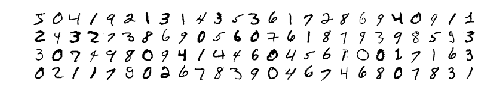

Epoch 0 : Sampling Image: 


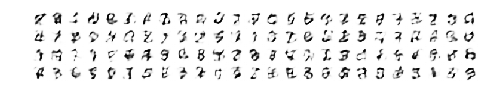

Epoch 0 : Reconstruct Image: 


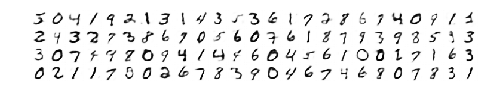

[1/100] - ptime: 23.31 Total_loss=(L+KL): 152.409 = (126.008+26.401)
Epoch 1 : Sampling Image: 


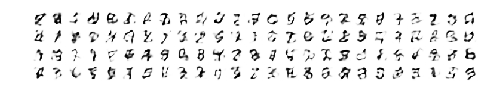

Epoch 1 : Reconstruct Image: 


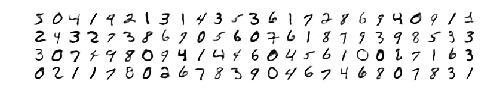

[2/100] - ptime: 21.84 Total_loss=(L+KL): 105.817 = (81.987+23.830)
Epoch 2 : Sampling Image: 


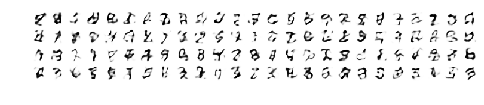

Epoch 2 : Reconstruct Image: 


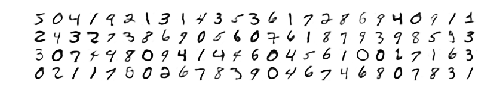

[3/100] - ptime: 21.88 Total_loss=(L+KL): 99.234 = (76.357+22.877)
Epoch 3 : Sampling Image: 


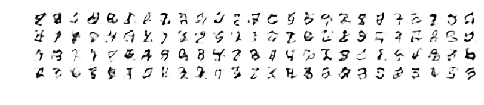

Epoch 3 : Reconstruct Image: 


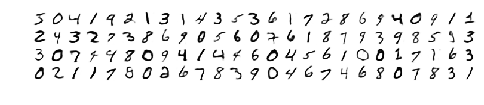

[4/100] - ptime: 21.81 Total_loss=(L+KL): 96.390 = (73.880+22.511)
Epoch 4 : Sampling Image: 


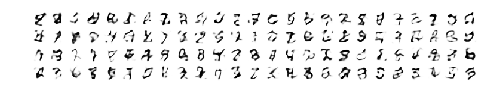

Epoch 4 : Reconstruct Image: 


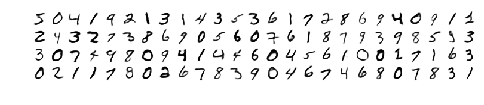

[5/100] - ptime: 21.69 Total_loss=(L+KL): 94.744 = (72.409+22.335)
Epoch 5 : Sampling Image: 


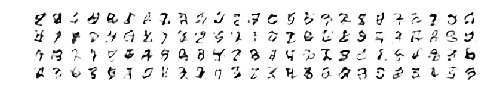

Epoch 5 : Reconstruct Image: 


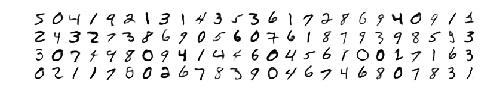

[6/100] - ptime: 21.80 Total_loss=(L+KL): 93.560 = (71.369+22.192)
Epoch 6 : Sampling Image: 


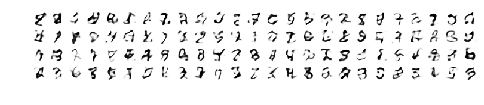

Epoch 6 : Reconstruct Image: 


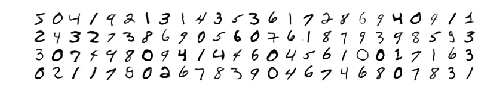

[7/100] - ptime: 21.81 Total_loss=(L+KL): 92.580 = (70.551+22.029)
Epoch 7 : Sampling Image: 


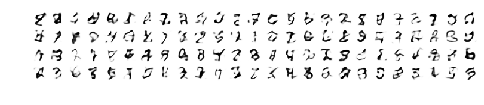

Epoch 7 : Reconstruct Image: 


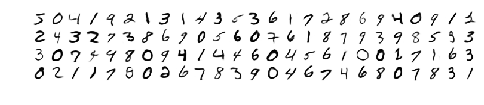

[8/100] - ptime: 22.10 Total_loss=(L+KL): 91.886 = (69.961+21.925)
Epoch 8 : Sampling Image: 


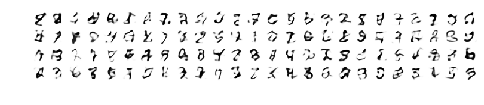

Epoch 8 : Reconstruct Image: 


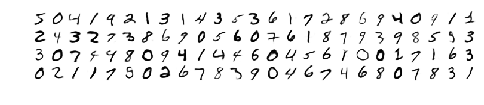

[9/100] - ptime: 21.81 Total_loss=(L+KL): 91.146 = (69.338+21.808)
Epoch 9 : Sampling Image: 


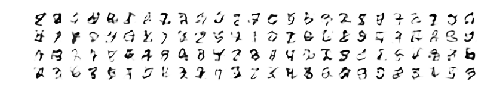

Epoch 9 : Reconstruct Image: 


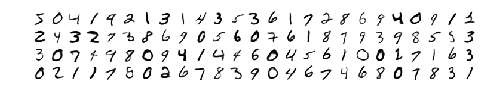

[10/100] - ptime: 21.82 Total_loss=(L+KL): 90.531 = (68.853+21.677)
Epoch 10 : Sampling Image: 


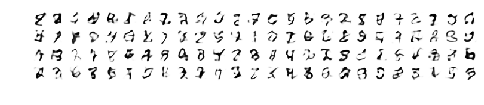

Epoch 10 : Reconstruct Image: 


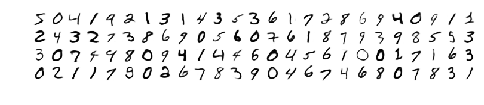

[11/100] - ptime: 21.61 Total_loss=(L+KL): 90.059 = (68.484+21.574)
Epoch 11 : Sampling Image: 


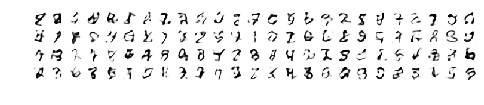

Epoch 11 : Reconstruct Image: 


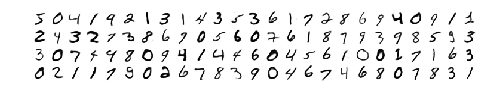

[12/100] - ptime: 21.71 Total_loss=(L+KL): 89.563 = (68.080+21.483)
Epoch 12 : Sampling Image: 


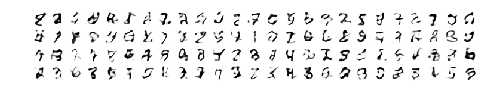

Epoch 12 : Reconstruct Image: 


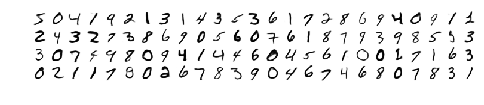

[13/100] - ptime: 21.75 Total_loss=(L+KL): 89.038 = (67.680+21.359)
Epoch 13 : Sampling Image: 


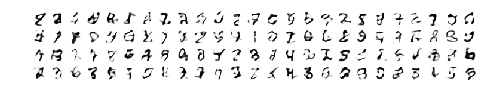

Epoch 13 : Reconstruct Image: 


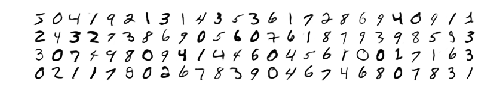

[14/100] - ptime: 21.80 Total_loss=(L+KL): 88.712 = (67.399+21.313)
Epoch 14 : Sampling Image: 


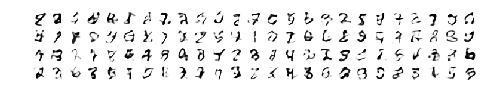

Epoch 14 : Reconstruct Image: 


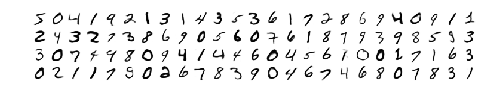

[15/100] - ptime: 21.77 Total_loss=(L+KL): 88.298 = (67.085+21.213)
Epoch 15 : Sampling Image: 


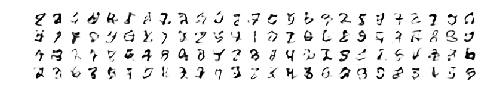

Epoch 15 : Reconstruct Image: 


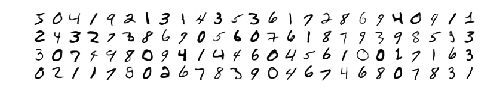

[16/100] - ptime: 22.06 Total_loss=(L+KL): 87.930 = (66.803+21.126)
Epoch 16 : Sampling Image: 


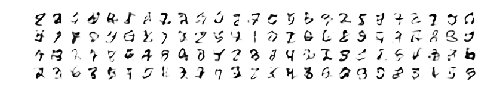

Epoch 16 : Reconstruct Image: 


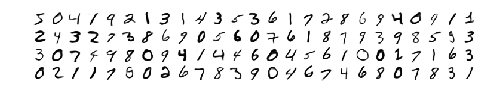

[17/100] - ptime: 21.77 Total_loss=(L+KL): 87.613 = (66.566+21.047)
Epoch 17 : Sampling Image: 


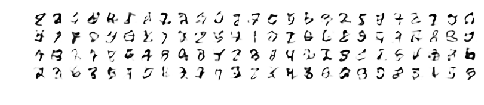

Epoch 17 : Reconstruct Image: 


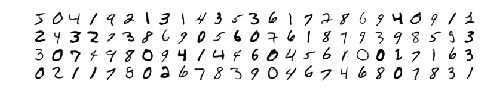

[18/100] - ptime: 21.48 Total_loss=(L+KL): 87.297 = (66.300+20.997)
Epoch 18 : Sampling Image: 


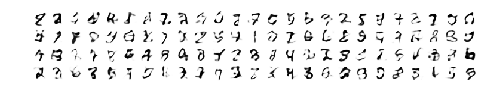

Epoch 18 : Reconstruct Image: 


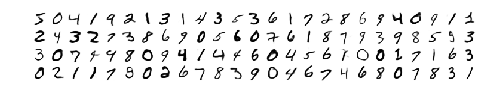

[19/100] - ptime: 21.75 Total_loss=(L+KL): 87.042 = (66.112+20.930)
Epoch 19 : Sampling Image: 


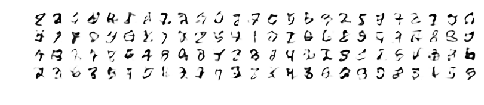

Epoch 19 : Reconstruct Image: 


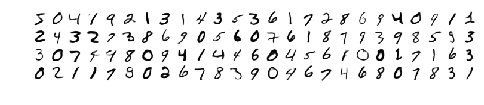

[20/100] - ptime: 22.05 Total_loss=(L+KL): 86.765 = (65.907+20.857)
Epoch 20 : Sampling Image: 


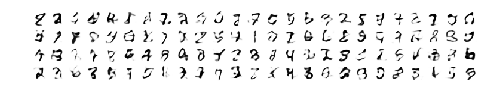

Epoch 20 : Reconstruct Image: 


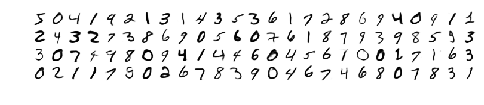

[21/100] - ptime: 22.43 Total_loss=(L+KL): 86.530 = (65.720+20.810)
Epoch 21 : Sampling Image: 


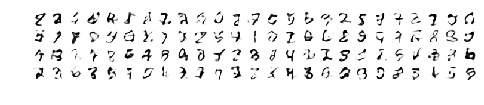

Epoch 21 : Reconstruct Image: 


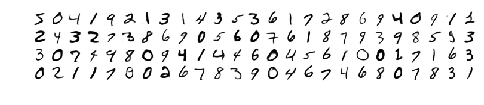

[22/100] - ptime: 21.72 Total_loss=(L+KL): 86.266 = (65.523+20.744)
Epoch 22 : Sampling Image: 


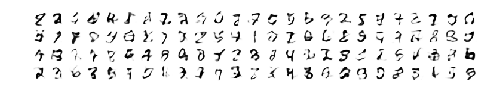

Epoch 22 : Reconstruct Image: 


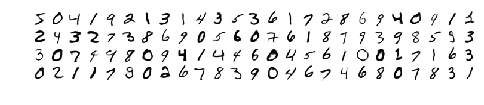

[23/100] - ptime: 21.61 Total_loss=(L+KL): 86.050 = (65.367+20.682)
Epoch 23 : Sampling Image: 


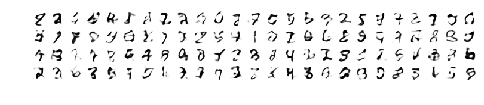

Epoch 23 : Reconstruct Image: 


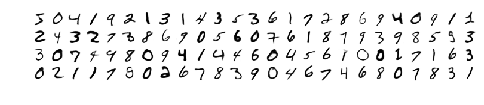

[24/100] - ptime: 21.59 Total_loss=(L+KL): 85.863 = (65.220+20.642)
Epoch 24 : Sampling Image: 


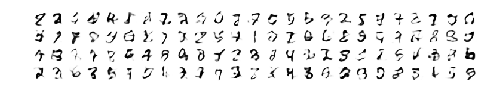

Epoch 24 : Reconstruct Image: 


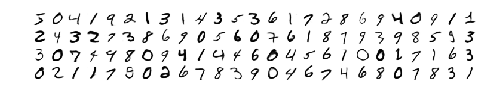

[25/100] - ptime: 21.59 Total_loss=(L+KL): 85.637 = (65.065+20.572)
Epoch 25 : Sampling Image: 


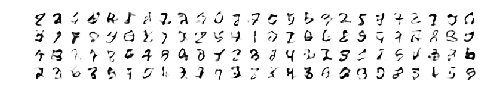

Epoch 25 : Reconstruct Image: 


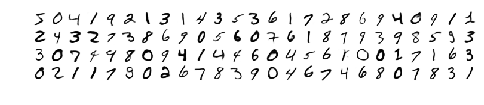

[26/100] - ptime: 21.60 Total_loss=(L+KL): 85.422 = (64.895+20.526)
Epoch 26 : Sampling Image: 


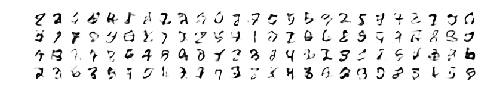

Epoch 26 : Reconstruct Image: 


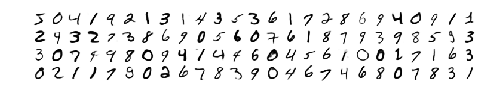

[27/100] - ptime: 21.73 Total_loss=(L+KL): 85.266 = (64.779+20.487)
Epoch 27 : Sampling Image: 


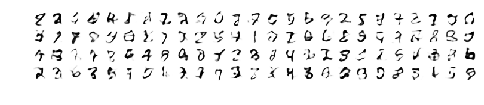

Epoch 27 : Reconstruct Image: 


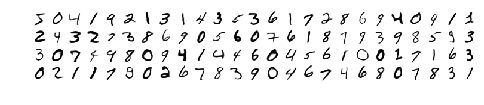

[28/100] - ptime: 21.72 Total_loss=(L+KL): 85.098 = (64.650+20.448)
Epoch 28 : Sampling Image: 


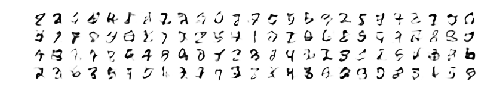

Epoch 28 : Reconstruct Image: 


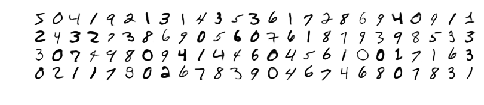

[29/100] - ptime: 21.73 Total_loss=(L+KL): 84.965 = (64.548+20.417)
Epoch 29 : Sampling Image: 


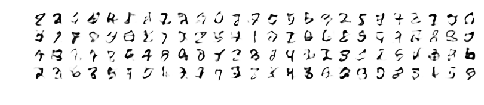

Epoch 29 : Reconstruct Image: 


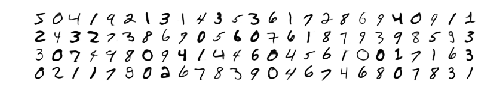

[30/100] - ptime: 22.62 Total_loss=(L+KL): 84.769 = (64.407+20.362)
Epoch 30 : Sampling Image: 


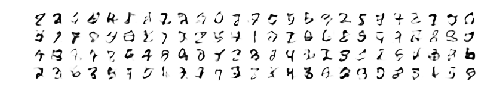

Epoch 30 : Reconstruct Image: 


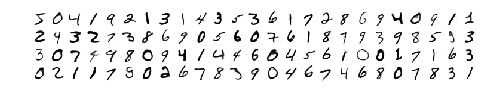

[31/100] - ptime: 21.72 Total_loss=(L+KL): 84.623 = (64.313+20.310)
Epoch 31 : Sampling Image: 


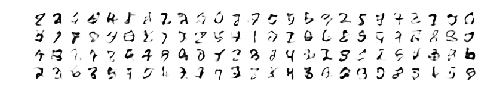

Epoch 31 : Reconstruct Image: 


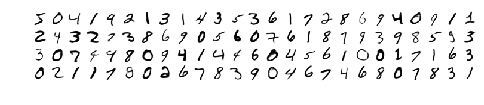

[32/100] - ptime: 21.49 Total_loss=(L+KL): 84.474 = (64.191+20.283)
Epoch 32 : Sampling Image: 


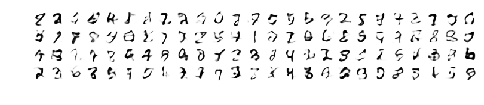

Epoch 32 : Reconstruct Image: 


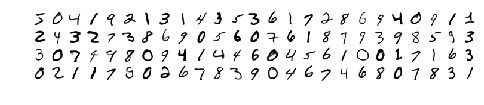

[33/100] - ptime: 21.53 Total_loss=(L+KL): 84.373 = (64.133+20.240)
Epoch 33 : Sampling Image: 


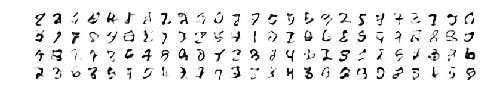

Epoch 33 : Reconstruct Image: 


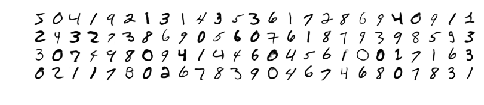

[34/100] - ptime: 21.55 Total_loss=(L+KL): 84.267 = (64.056+20.211)
Epoch 34 : Sampling Image: 


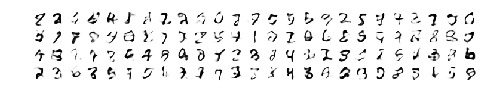

Epoch 34 : Reconstruct Image: 


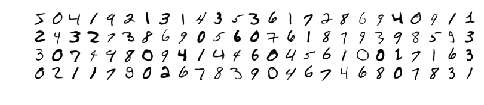

[35/100] - ptime: 21.54 Total_loss=(L+KL): 84.116 = (63.938+20.179)
Epoch 35 : Sampling Image: 


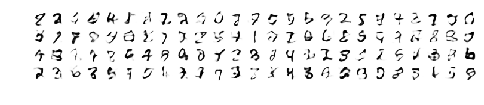

Epoch 35 : Reconstruct Image: 


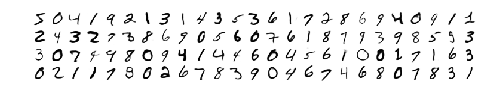

[36/100] - ptime: 21.93 Total_loss=(L+KL): 84.001 = (63.849+20.152)
Epoch 36 : Sampling Image: 


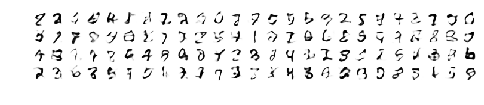

Epoch 36 : Reconstruct Image: 


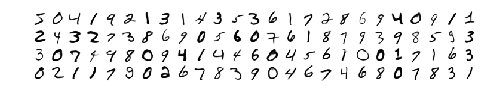

[37/100] - ptime: 21.73 Total_loss=(L+KL): 83.899 = (63.782+20.116)
Epoch 37 : Sampling Image: 


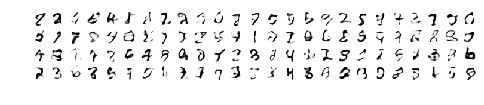

Epoch 37 : Reconstruct Image: 


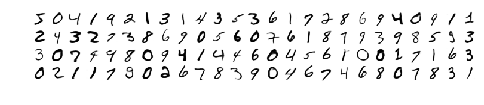

[38/100] - ptime: 21.59 Total_loss=(L+KL): 83.772 = (63.705+20.067)
Epoch 38 : Sampling Image: 


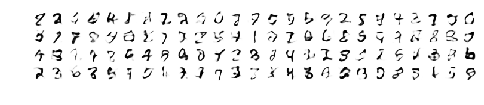

Epoch 38 : Reconstruct Image: 


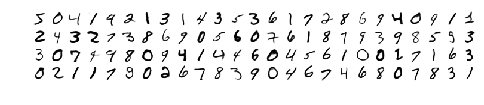

[39/100] - ptime: 22.17 Total_loss=(L+KL): 83.672 = (63.625+20.047)
Epoch 39 : Sampling Image: 


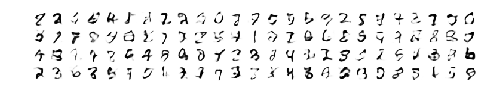

Epoch 39 : Reconstruct Image: 


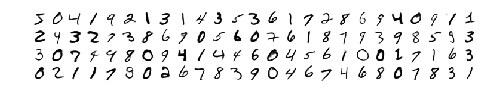

[40/100] - ptime: 22.22 Total_loss=(L+KL): 83.577 = (63.557+20.019)
Epoch 40 : Sampling Image: 


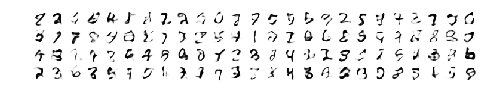

Epoch 40 : Reconstruct Image: 


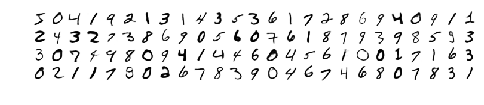

[41/100] - ptime: 21.64 Total_loss=(L+KL): 83.519 = (63.515+20.005)
Epoch 41 : Sampling Image: 


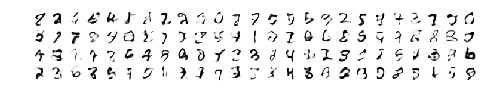

Epoch 41 : Reconstruct Image: 


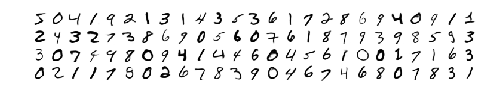

[42/100] - ptime: 21.50 Total_loss=(L+KL): 83.391 = (63.441+19.950)
Epoch 42 : Sampling Image: 


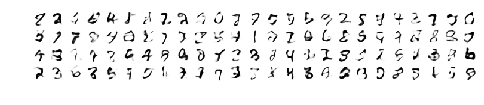

Epoch 42 : Reconstruct Image: 


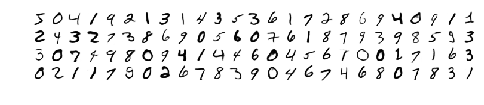

[43/100] - ptime: 21.48 Total_loss=(L+KL): 83.260 = (63.363+19.896)
Epoch 43 : Sampling Image: 


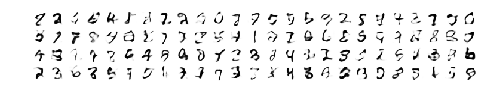

Epoch 43 : Reconstruct Image: 


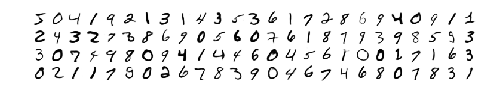

[44/100] - ptime: 21.80 Total_loss=(L+KL): 83.216 = (63.321+19.895)
Epoch 44 : Sampling Image: 


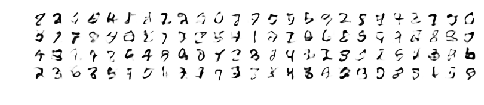

Epoch 44 : Reconstruct Image: 


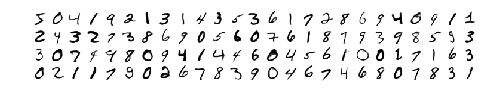

[45/100] - ptime: 21.38 Total_loss=(L+KL): 83.131 = (63.267+19.864)
Epoch 45 : Sampling Image: 


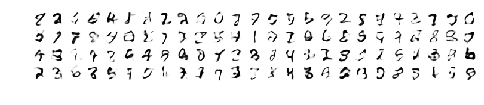

Epoch 45 : Reconstruct Image: 


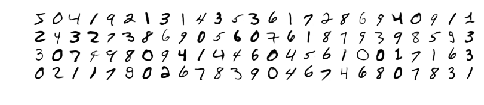

[46/100] - ptime: 21.87 Total_loss=(L+KL): 83.039 = (63.207+19.832)
Epoch 46 : Sampling Image: 


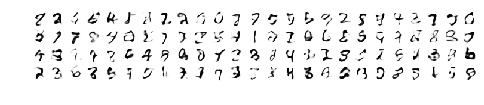

Epoch 46 : Reconstruct Image: 


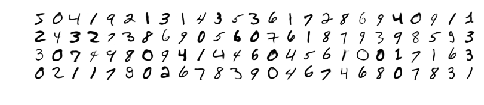

[47/100] - ptime: 21.49 Total_loss=(L+KL): 82.953 = (63.162+19.791)
Epoch 47 : Sampling Image: 


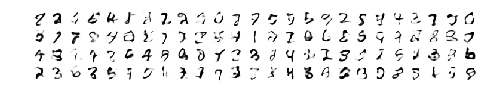

Epoch 47 : Reconstruct Image: 


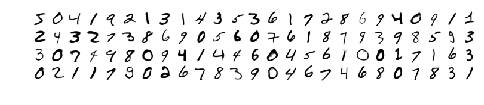

[48/100] - ptime: 21.97 Total_loss=(L+KL): 82.867 = (63.096+19.771)
Epoch 48 : Sampling Image: 


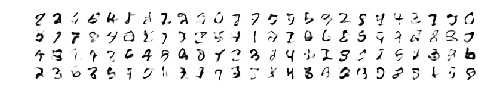

Epoch 48 : Reconstruct Image: 


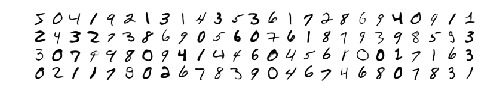

[49/100] - ptime: 22.52 Total_loss=(L+KL): 82.825 = (63.062+19.763)
Epoch 49 : Sampling Image: 


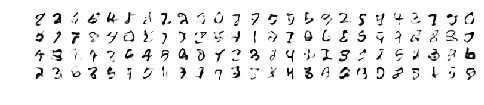

Epoch 49 : Reconstruct Image: 


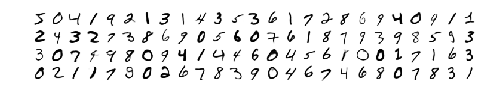

[50/100] - ptime: 22.21 Total_loss=(L+KL): 82.727 = (63.011+19.716)
Epoch 50 : Sampling Image: 


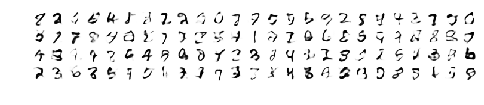

Epoch 50 : Reconstruct Image: 


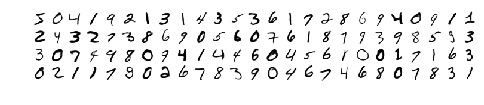

[51/100] - ptime: 21.48 Total_loss=(L+KL): 82.697 = (62.989+19.708)
Epoch 51 : Sampling Image: 


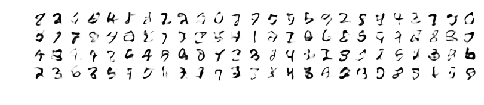

Epoch 51 : Reconstruct Image: 


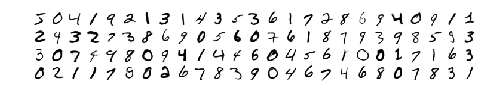

[52/100] - ptime: 21.48 Total_loss=(L+KL): 82.611 = (62.916+19.695)
Epoch 52 : Sampling Image: 


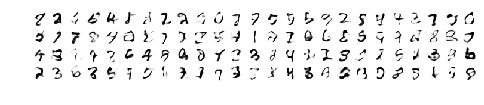

Epoch 52 : Reconstruct Image: 


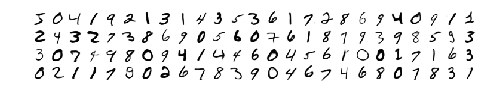

[53/100] - ptime: 22.07 Total_loss=(L+KL): 82.527 = (62.876+19.652)
Epoch 53 : Sampling Image: 


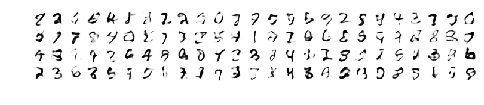

Epoch 53 : Reconstruct Image: 


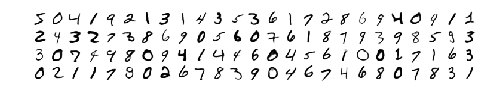

[54/100] - ptime: 21.54 Total_loss=(L+KL): 82.482 = (62.838+19.644)
Epoch 54 : Sampling Image: 


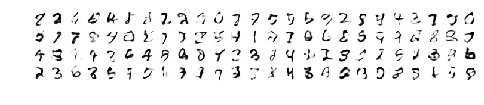

Epoch 54 : Reconstruct Image: 


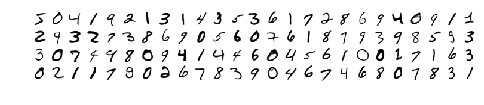

[55/100] - ptime: 21.80 Total_loss=(L+KL): 82.405 = (62.805+19.600)
Epoch 55 : Sampling Image: 


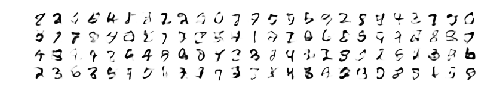

Epoch 55 : Reconstruct Image: 


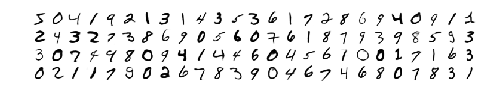

[56/100] - ptime: 21.93 Total_loss=(L+KL): 82.324 = (62.755+19.569)
Epoch 56 : Sampling Image: 


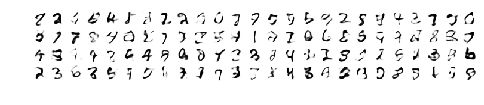

Epoch 56 : Reconstruct Image: 


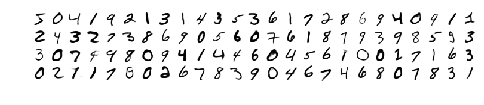

[57/100] - ptime: 21.53 Total_loss=(L+KL): 82.287 = (62.720+19.567)
Epoch 57 : Sampling Image: 


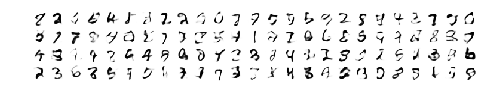

Epoch 57 : Reconstruct Image: 


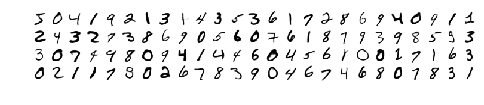

[58/100] - ptime: 22.73 Total_loss=(L+KL): 82.247 = (62.692+19.555)
Epoch 58 : Sampling Image: 


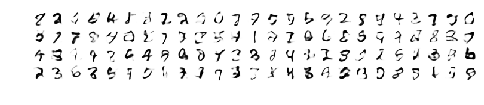

Epoch 58 : Reconstruct Image: 


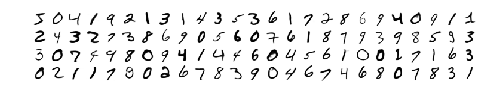

[59/100] - ptime: 22.80 Total_loss=(L+KL): 82.170 = (62.650+19.520)
Epoch 59 : Sampling Image: 


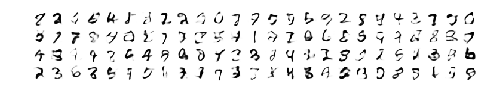

Epoch 59 : Reconstruct Image: 


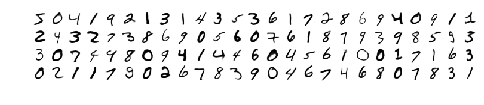

[60/100] - ptime: 21.53 Total_loss=(L+KL): 82.130 = (62.622+19.508)
Epoch 60 : Sampling Image: 


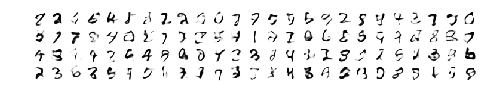

Epoch 60 : Reconstruct Image: 


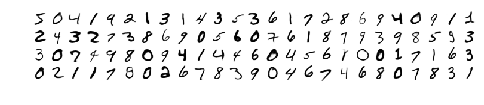

[61/100] - ptime: 21.50 Total_loss=(L+KL): 82.057 = (62.581+19.476)
Epoch 61 : Sampling Image: 


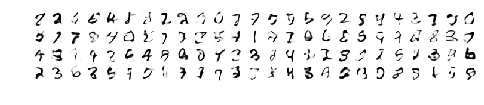

Epoch 61 : Reconstruct Image: 


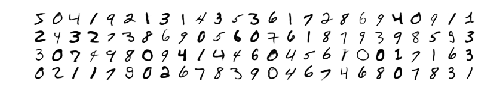

[62/100] - ptime: 21.52 Total_loss=(L+KL): 82.036 = (62.564+19.472)
Epoch 62 : Sampling Image: 


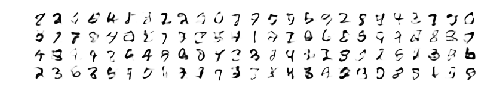

Epoch 62 : Reconstruct Image: 


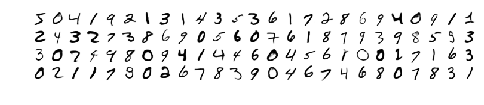

[63/100] - ptime: 21.52 Total_loss=(L+KL): 81.968 = (62.527+19.442)
Epoch 63 : Sampling Image: 


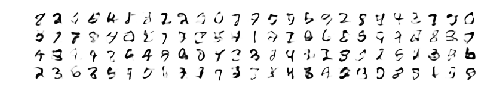

Epoch 63 : Reconstruct Image: 


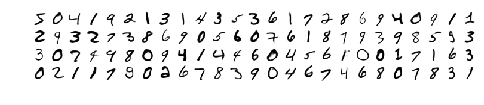

[64/100] - ptime: 21.52 Total_loss=(L+KL): 81.881 = (62.466+19.415)
Epoch 64 : Sampling Image: 


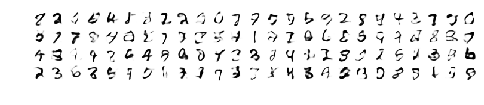

Epoch 64 : Reconstruct Image: 


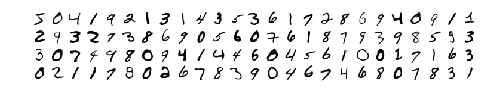

[65/100] - ptime: 21.52 Total_loss=(L+KL): 81.857 = (62.452+19.405)
Epoch 65 : Sampling Image: 


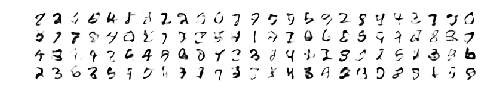

Epoch 65 : Reconstruct Image: 


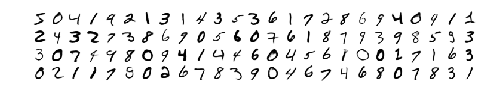

[66/100] - ptime: 22.11 Total_loss=(L+KL): 81.811 = (62.429+19.382)
Epoch 66 : Sampling Image: 


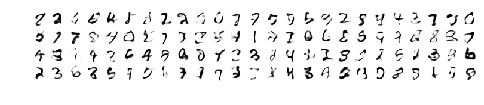

Epoch 66 : Reconstruct Image: 


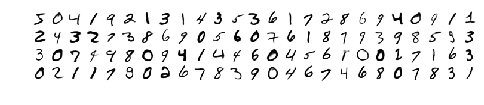

[67/100] - ptime: 22.76 Total_loss=(L+KL): 81.755 = (62.399+19.356)
Epoch 67 : Sampling Image: 


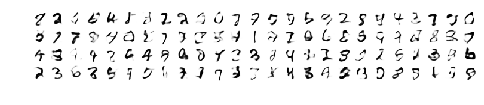

Epoch 67 : Reconstruct Image: 


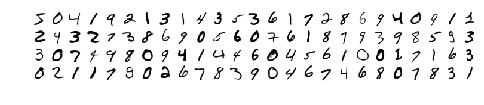

[68/100] - ptime: 21.83 Total_loss=(L+KL): 81.703 = (62.384+19.319)
Epoch 68 : Sampling Image: 


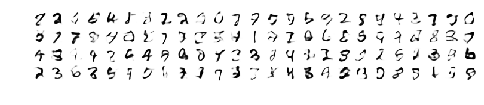

Epoch 68 : Reconstruct Image: 


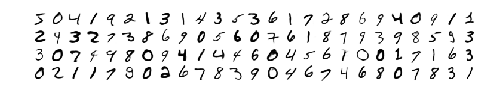

[69/100] - ptime: 21.50 Total_loss=(L+KL): 81.667 = (62.347+19.320)
Epoch 69 : Sampling Image: 


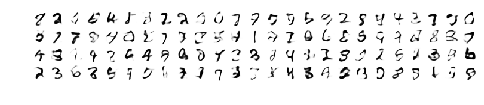

Epoch 69 : Reconstruct Image: 


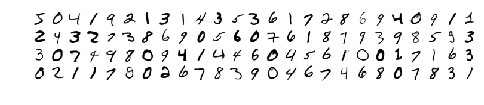

[70/100] - ptime: 21.53 Total_loss=(L+KL): 81.621 = (62.319+19.301)
Epoch 70 : Sampling Image: 


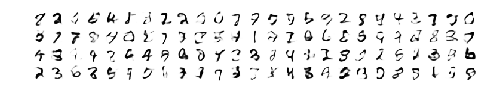

Epoch 70 : Reconstruct Image: 


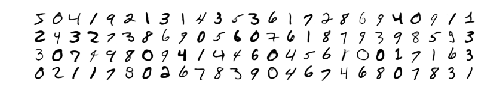

[71/100] - ptime: 21.45 Total_loss=(L+KL): 81.570 = (62.295+19.274)
Epoch 71 : Sampling Image: 


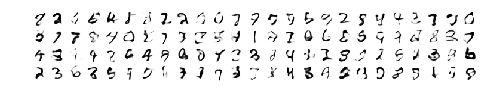

Epoch 71 : Reconstruct Image: 


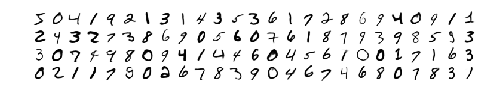

[72/100] - ptime: 21.56 Total_loss=(L+KL): 81.528 = (62.262+19.266)
Epoch 72 : Sampling Image: 


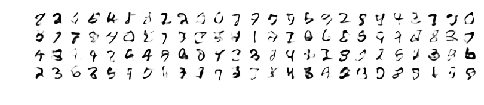

Epoch 72 : Reconstruct Image: 


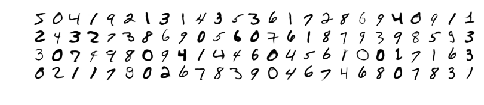

[73/100] - ptime: 21.48 Total_loss=(L+KL): 81.509 = (62.246+19.263)
Epoch 73 : Sampling Image: 


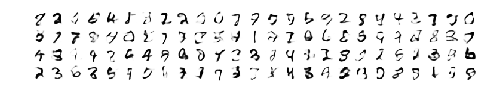

Epoch 73 : Reconstruct Image: 


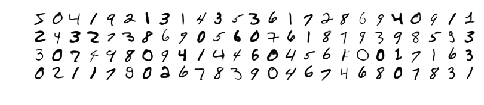

[74/100] - ptime: 21.45 Total_loss=(L+KL): 81.453 = (62.214+19.239)
Epoch 74 : Sampling Image: 


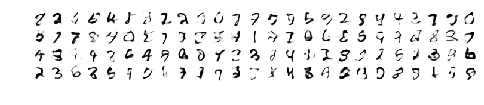

Epoch 74 : Reconstruct Image: 


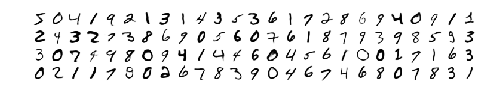

[75/100] - ptime: 21.53 Total_loss=(L+KL): 81.416 = (62.204+19.212)
Epoch 75 : Sampling Image: 


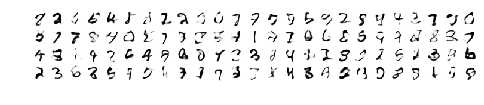

Epoch 75 : Reconstruct Image: 


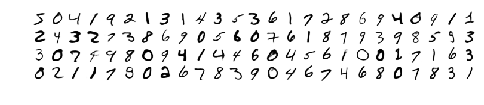

[76/100] - ptime: 22.19 Total_loss=(L+KL): 81.370 = (62.158+19.213)
Epoch 76 : Sampling Image: 


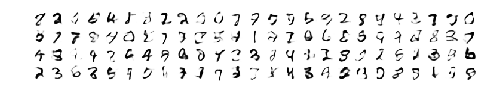

Epoch 76 : Reconstruct Image: 


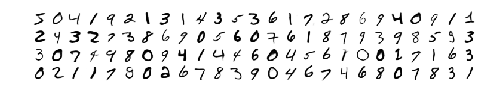

[77/100] - ptime: 22.34 Total_loss=(L+KL): 81.335 = (62.155+19.180)
Epoch 77 : Sampling Image: 


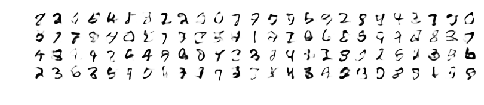

Epoch 77 : Reconstruct Image: 


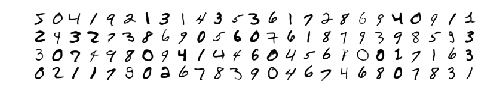

[78/100] - ptime: 21.63 Total_loss=(L+KL): 81.309 = (62.133+19.176)
Epoch 78 : Sampling Image: 


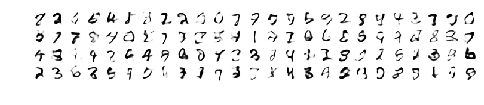

Epoch 78 : Reconstruct Image: 


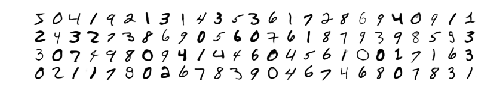

[79/100] - ptime: 21.45 Total_loss=(L+KL): 81.268 = (62.105+19.163)
Epoch 79 : Sampling Image: 


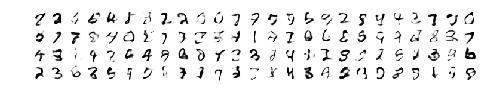

Epoch 79 : Reconstruct Image: 


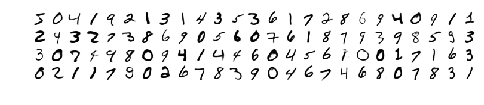

[80/100] - ptime: 21.69 Total_loss=(L+KL): 81.231 = (62.097+19.134)
Epoch 80 : Sampling Image: 


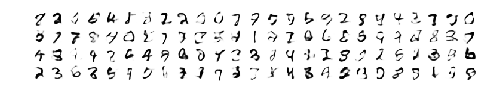

Epoch 80 : Reconstruct Image: 


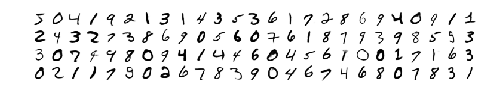

[81/100] - ptime: 21.48 Total_loss=(L+KL): 81.192 = (62.069+19.124)
Epoch 81 : Sampling Image: 


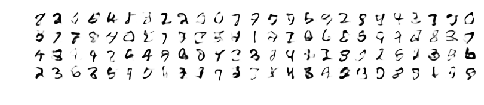

Epoch 81 : Reconstruct Image: 


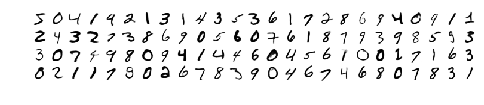

[82/100] - ptime: 21.49 Total_loss=(L+KL): 81.166 = (62.039+19.127)
Epoch 82 : Sampling Image: 


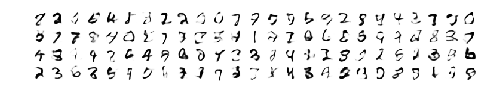

Epoch 82 : Reconstruct Image: 


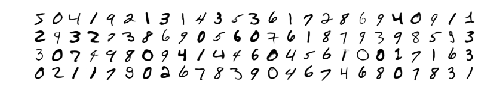

[83/100] - ptime: 21.52 Total_loss=(L+KL): 81.114 = (62.017+19.098)
Epoch 83 : Sampling Image: 


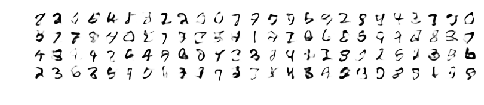

Epoch 83 : Reconstruct Image: 


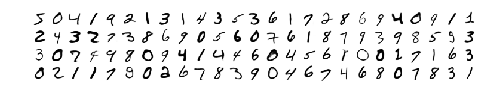

[84/100] - ptime: 21.51 Total_loss=(L+KL): 81.094 = (61.996+19.098)
Epoch 84 : Sampling Image: 


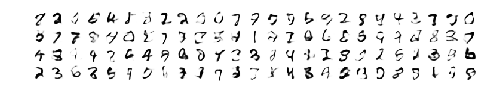

Epoch 84 : Reconstruct Image: 


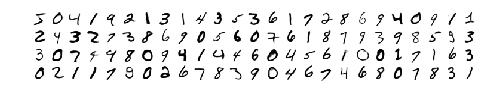

[85/100] - ptime: 22.01 Total_loss=(L+KL): 81.056 = (61.979+19.077)
Epoch 85 : Sampling Image: 


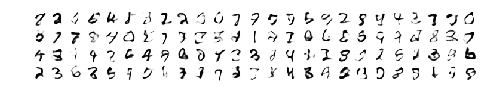

Epoch 85 : Reconstruct Image: 


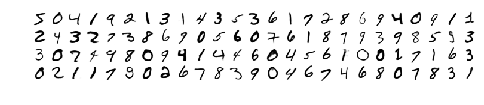

[86/100] - ptime: 22.08 Total_loss=(L+KL): 81.006 = (61.955+19.051)
Epoch 86 : Sampling Image: 


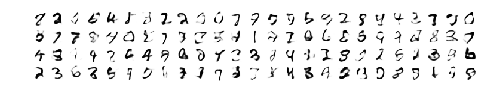

Epoch 86 : Reconstruct Image: 


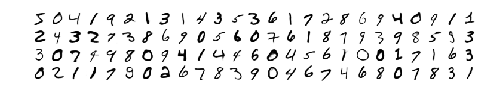

[87/100] - ptime: 21.63 Total_loss=(L+KL): 81.000 = (61.954+19.046)
Epoch 87 : Sampling Image: 


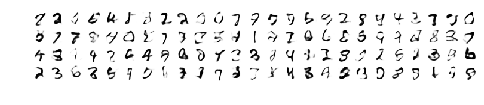

Epoch 87 : Reconstruct Image: 


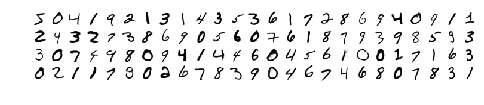

[88/100] - ptime: 21.36 Total_loss=(L+KL): 80.954 = (61.932+19.022)
Epoch 88 : Sampling Image: 


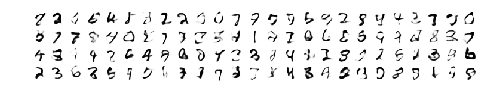

Epoch 88 : Reconstruct Image: 


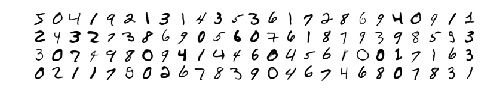

[89/100] - ptime: 21.51 Total_loss=(L+KL): 80.918 = (61.906+19.012)
Epoch 89 : Sampling Image: 


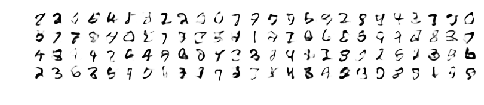

Epoch 89 : Reconstruct Image: 


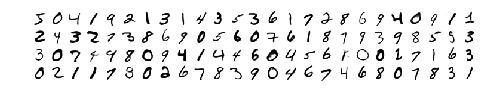

[90/100] - ptime: 21.53 Total_loss=(L+KL): 80.875 = (61.879+18.996)
Epoch 90 : Sampling Image: 


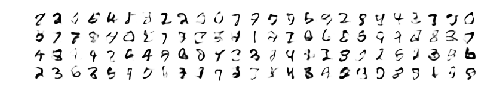

Epoch 90 : Reconstruct Image: 


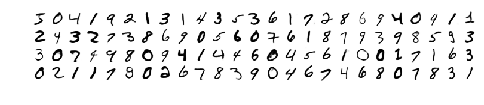

[91/100] - ptime: 22.27 Total_loss=(L+KL): 80.859 = (61.871+18.988)
Epoch 91 : Sampling Image: 


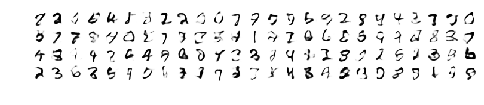

Epoch 91 : Reconstruct Image: 


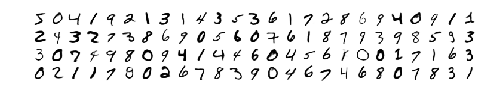

[92/100] - ptime: 53.82 Total_loss=(L+KL): 80.823 = (61.850+18.973)
Epoch 92 : Sampling Image: 


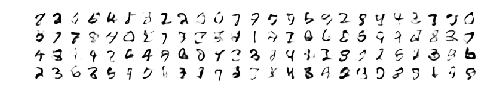

Epoch 92 : Reconstruct Image: 


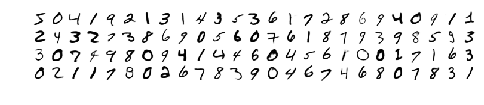

[93/100] - ptime: 56.49 Total_loss=(L+KL): 80.802 = (61.841+18.961)
Epoch 93 : Sampling Image: 


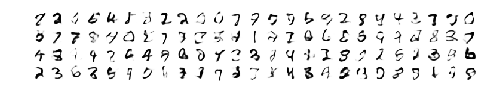

Epoch 93 : Reconstruct Image: 


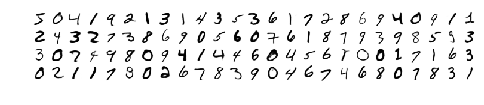

[94/100] - ptime: 56.43 Total_loss=(L+KL): 80.763 = (61.814+18.948)
Epoch 94 : Sampling Image: 


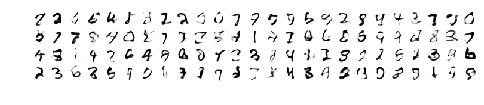

Epoch 94 : Reconstruct Image: 


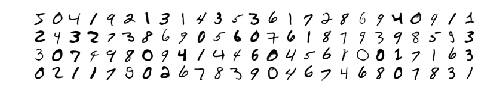

[95/100] - ptime: 56.53 Total_loss=(L+KL): 80.735 = (61.798+18.938)
Epoch 95 : Sampling Image: 


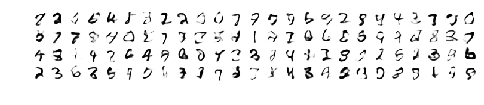

Epoch 95 : Reconstruct Image: 


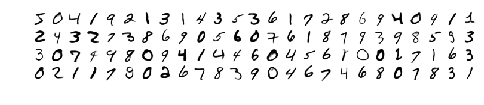

[96/100] - ptime: 57.02 Total_loss=(L+KL): 80.722 = (61.793+18.929)
Epoch 96 : Sampling Image: 


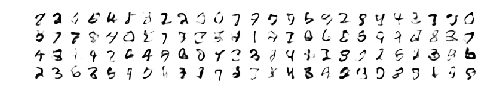

Epoch 96 : Reconstruct Image: 


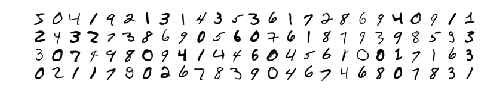

[97/100] - ptime: 57.11 Total_loss=(L+KL): 80.694 = (61.773+18.922)
Epoch 97 : Sampling Image: 


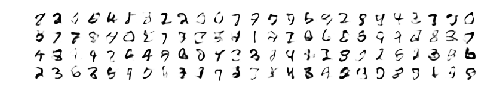

Epoch 97 : Reconstruct Image: 


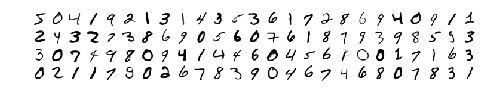

[98/100] - ptime: 56.77 Total_loss=(L+KL): 80.637 = (61.742+18.895)
Epoch 98 : Sampling Image: 


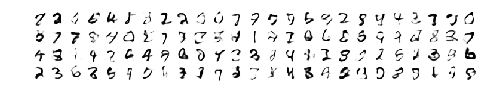

Epoch 98 : Reconstruct Image: 


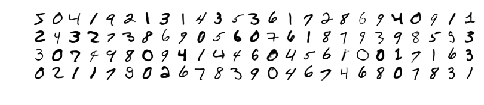

[99/100] - ptime: 29.03 Total_loss=(L+KL): 80.630 = (61.732+18.898)
Epoch 99 : Sampling Image: 


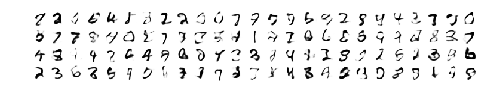

Epoch 99 : Reconstruct Image: 


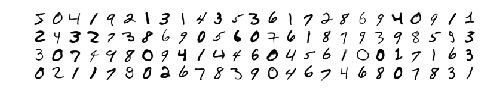

[100/100] - ptime: 21.63 Total_loss=(L+KL): 80.586 = (61.706+18.880)


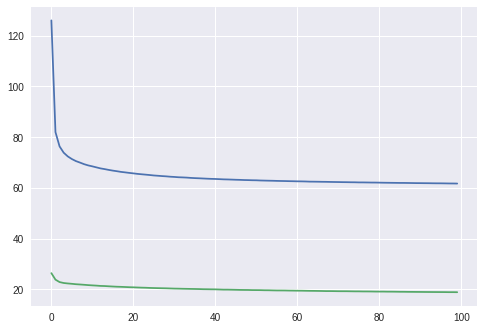

In [3]:
with tf.Session() as sess:
    vae = VAE(sess, image_size=28, batch_size=100, z_dim=200)
    vae.train(num_epoch=100, lr=0.0002, beta1=0.5)